# SatCen Change Detection using SNAP and Sentinel-1 data

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Data](#data)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

This notebook produces a Change Detection analysis using the Sentinel Application Platform (SNAP) and Sentinel-1 Level-1 Ground Range Detected.

## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Sentinel-1 data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

## <a name="service">Service definition

#### Service

In [1]:
service = dict([('title', 'SatCen Change Detection'),
                ('abstract', 'SatCen Change Detection using SNAP and Sentinel-1 data'),
                ('id', 'satcen-change-detection')])

#### Parameters

In [2]:
aoi_wkt = dict([('id', 'aoi_wkt'),
               ('value', 'POLYGON((-3.611068725585937 40.57602136929037,-3.611068725585937 40.42669550575275,-3.4047317504882812 40.42669550575275,-3.4047317504882812 40.57602136929037,-3.611068725585937 40.57602136929037))'),
               ('title', 'Area of nterest'),
               ('abstract', 'Area of interest expressed as a WKT polygon')])

In [3]:
polarization = dict([('id', 'polarization'),
               ('value', 'VH'),
               ('title', 'Sentinel-1 polarization'),
               ('abstract', 'Sentinel-1 polarization (e.g. VH)')])

## <a name="workflow">Workflow

#### Set the parameters

In [4]:
data_path = '/workspace/data'

In [5]:
input_references = ('https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20180312T061753_20180312T061818_020978_024034_457D',
                   'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18')

In [6]:
input_identifiers = ('S1A_IW_GRDH_1SDV_20180312T061753_20180312T061818_020978_024034_457D', 
           'S1A_IW_GRDH_1SDV_20180216T061753_20180216T061818_020628_02351B_9F18')

In [7]:
slave_identifier = input_identifiers[0]

In [8]:
master_identifier = input_identifiers[1]

#### Import the python packages

In [9]:
import owslib
from owslib.wps import monitorExecution
import uuid
from owslib.wps import WebProcessingService
import sys
import os
sys.path.append('/opt/anaconda/bin/')
import lxml.etree as etree
os.environ["TMPDIR"] = '1'
os.environ["_CIOP_APPLICATION_PATH"] = '/'
import requests
import cioppy
ciop = cioppy.Cioppy()
import shapely
import dateutil.parser
from shapely.wkt import loads 
import pandas as pd
import geopandas as gp
from datetime import datetime, timedelta
from io import BytesIO
from zipfile import ZipFile
%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np
import snappy
import gc
import json
from os.path import exists
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
from struct import unpack
import Image
import ImageDraw
from PIL import Image
from mimetypes import MimeTypes
from os.path import exists
%load_ext autoreload
%autoreload 2


#### Read the master and slave

In [10]:
slave_prd = "%s/%s/%s.SAFE/manifest.safe" % (data_path, slave_identifier, slave_identifier)
slave = snappy.ProductIO.readProduct(slave_prd)

master_prd = "%s/%s/%s.SAFE/manifest.safe" % (data_path, master_identifier, master_identifier)
master = snappy.ProductIO.readProduct(master_prd)

#### Subset master and slave

In [11]:
HashMap = snappy.jpy.get_type('java.util.HashMap')
    
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()

parameters.put('geoRegion', aoi_wkt['value'],)
parameters.put('subSamplingX', '1')
parameters.put('subSamplingY', '1')
parameters.put('fullSwath', 'false')
parameters.put('copyMetadata', 'true')

In [12]:
slave_subset = snappy.GPF.createProduct('Subset', parameters, slave)
master_subset = snappy.GPF.createProduct('Subset', parameters, master)

#### Apply the orbit files to the subset master and slave

In [13]:
parameters = HashMap()

parameters.put('orbitType', 'Sentinel Precise (Auto Download)')
parameters.put('polyDegree', '3')
parameters.put('continueOnFail', 'true')

In [14]:
slave_orbit_applied = snappy.GPF.createProduct('Apply-Orbit-File', parameters, slave_subset)
master_orbit_applied = snappy.GPF.createProduct('Apply-Orbit-File', parameters, master_subset)

#### Remove the thermal noise master and slave

In [15]:
parameters = HashMap()

parameters.put('removeThermalNoise', 'true')
parameters.put('reIntroduceThermalNoise', 'false')

In [16]:
slave_thermal_noise = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, slave_orbit_applied)
master_thermal_noise = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, master_orbit_applied)

#### Apply the calibration

In [17]:
parameters = HashMap()

parameters.put('auxFile', 'Product Auxiliary File')
parameters.put('outputImageInComplex','false')
parameters.put('outputImageScaleInDb','false')
parameters.put('createGammaBand', 'false')
parameters.put('createBetaBand', 'false')
parameters.put('selectedPolarisations', polarization['value'])
parameters.put('outputSigmaBand', 'true')
parameters.put('outputGammaBand', 'false')
parameters.put('outputBetaBand', 'false')              

In [18]:
slave_calibrated = snappy.GPF.createProduct('Calibration', parameters, slave_thermal_noise)
master_calibrated = snappy.GPF.createProduct('Calibration', parameters, master_thermal_noise)

#### Terrain Correction

In [19]:
parameters = HashMap()

parameters.put('demName', 'SRTM 3Sec')
parameters.put('externalDEMFile', '')
parameters.put('externalDEMNoDataValue', '0.0')
parameters.put('externalDEMApplyEGM', 'true')
parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', '10.0')
#parameters.put('pixelSpacingInDegree', '8.983152841195215E-5')
parameters.put('mapProjection', 'AUTO:42001')
parameters.put('nodataValueAtSea', 'true')
parameters.put('saveDEM', 'false')
parameters.put('saveLatLon', 'false')
parameters.put('saveIncidenceAngleFromEllipsoid', 'false')
parameters.put('saveProjectedLocalIncidenceAngle', 'false')
parameters.put('saveSelectedSourceBand', 'true')
parameters.put('outputComplex', 'false')
parameters.put('applyRadiometricNormalization', 'false')
parameters.put('saveSigmaNought', 'false')
parameters.put('saveGammaNought', 'false')
parameters.put('saveBetaNought', 'false')
parameters.put('incidenceAngleForSigma0', 'Use projected local incidence angle from DEM')
parameters.put('incidenceAngleForGamma0', 'Use projected local incidence angle from DEM')
parameters.put('auxFile', 'Latest Auxiliary File')



In [20]:
slave_tc = snappy.GPF.createProduct('Terrain-Correction', parameters, slave_calibrated)
master_tc = snappy.GPF.createProduct('Terrain-Correction', parameters, master_calibrated)

#### Stack the master and slave

In [21]:
parameters = HashMap()

parameters.put('resamplingType', 'BICUBIC_INTERPOLATION')
parameters.put('extent', 'Minimum')
parameters.put('initialOffsetMethod', 'Orbit')

stack = snappy.GPF.createProduct('CreateStack', parameters, [master_calibrated, slave_calibrated])



#### Apply the change detection band arithmetic expression

In [22]:
for index, band in enumerate(stack.getBandNames()):
    print band



Sigma0_VH_mst_12Mar2018
Sigma0_VH_slv1_16Feb2018


In [23]:
change_detection_expression = '({0} > 0.0001) && ({1} > 0.0001) && (abs(log10({0} / {1})) > 1) && ({0} > 0.05 || {1} >0.05)'.format(stack.getBandNames()[0], stack.getBandNames()[1])


In [24]:
BandDescriptor = snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand0 = BandDescriptor()
targetBand0.name = 'change_detection_%s' % polarization['value']
targetBand0.type = 'uint16'
targetBand0.expression = change_detection_expression

targetBands = snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand0

parameters = HashMap()
parameters.put('targetBands', targetBands)

change_detection = snappy.GPF.createProduct('BandMaths', parameters, stack)

#### Plot the result

In [25]:
def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
    return imgplot 

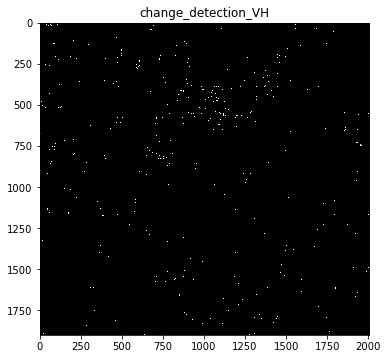

1181

In [26]:
fig = plt.figure(figsize=(20,20))

for index, band in enumerate(change_detection.getBandNames()):
        
    a=fig.add_subplot(4,4,index+1)
    imgplot = plotBand(change_detection, band, 0, 1)
    a.set_title(band)
    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()
gc.collect()

In [27]:
result_dir = '/workspace/EVER-EST'
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)


output_name = 'change_detection_%s_%s' % (stack.getBandNames()[0], stack.getBandNames()[1])

snappy.ProductIO.writeProduct(change_detection, output_name + '.tif', 'GeoTIFF')

In [28]:
stack = None
gc.collect()

0

In [29]:
change_detection_palette = {1: [61, 0, 253, 0],
                0: [0, 0, 0, 255]}

In [30]:
def raster2rgb(raster_file, color_table, out_file_name, raster_band=1, discrete=True):
    
    #Reading the band
    data_types ={'Byte':'B','UInt16':'H','Int16':'h','UInt32':'I','Int32':'i','Float32':'f','Float64':'d'}
    if exists(raster_file) is False:
            raise Exception('[Errno 2] No such file or directory: \'' + raster_file + '\'')    
    
    dataset = gdal.Open(raster_file, GA_ReadOnly )
    
    if dataset == None:
        raise Exception("Unable to read the data file")
        
    geoTransform = dataset.GetGeoTransform()
    proj = dataset.GetProjection()
    
    band = dataset.GetRasterBand(raster_band)
    values = band.ReadRaster( 0, 0, band.XSize, band.YSize, band.XSize, band.YSize, band.DataType )
    values = unpack(data_types[gdal.GetDataTypeName(band.DataType)]*band.XSize*band.YSize,values)
    
    #Preparing the color table and the output file
    classification_values = color_table.keys()
    classification_values.sort()
    
    base = Image.new( 'RGBA', (band.XSize,band.YSize) )
    base_draw = ImageDraw.Draw(base)
    alpha_mask = Image.new('L', (band.XSize,band.YSize), 255)
    alpha_draw = ImageDraw.Draw(alpha_mask)
    
    #Reading the value and setting the output color for each pixel
    for pos in range(len(values)):
        y = pos/band.XSize
        x = pos - y * band.XSize
        for index in range(len(classification_values)):

            if values[pos] <= classification_values[index] or index == len(classification_values)-1:
                if discrete == True:
                    if index == 0:
                        index = 1
                    elif index == len(classification_values)-1 and values[pos] >= classification_values[index]:
                        index = index + 1
                    color = color_table[classification_values[index-1]]
                    base_draw.point((x,y), (color[0],color[1],color[2]))
                    alpha_draw.point((x,y),color[3])
                else:
                    if index == 0:
                        r = color_table[classification_values[0]][0]
                        g = color_table[classification_values[0]][1]
                        b = color_table[classification_values[0]][2]
                        a = color_table[classification_values[0]][3]
                    elif index == len(classification_values)-1 and values[pos] >= classification_values[index]:
                        r = color_table[classification_values[index]][0]
                        g = color_table[classification_values[index]][1]
                        b = color_table[classification_values[index]][2]
                        a = color_table[classification_values[index]][3]
                    else:
                        r = color_table[classification_values[index-1]][0] + (values[pos] - classification_values[index-1])*(color_table[classification_values[index]][0] - color_table[classification_values[index-1]][0])/(classification_values[index]-classification_values[index-1]) 
                        g = color_table[classification_values[index-1]][1] + (values[pos] - classification_values[index-1])*(color_table[classification_values[index]][1] - color_table[classification_values[index-1]][1])/(classification_values[index]-classification_values[index-1]) 
                        b = color_table[classification_values[index-1]][2] + (values[pos] - classification_values[index-1])*(color_table[classification_values[index]][2] - color_table[classification_values[index-1]][2])/(classification_values[index]-classification_values[index-1]) 
                        a = color_table[classification_values[index-1]][3] + (values[pos] - classification_values[index-1])*(color_table[classification_values[index]][3] - color_table[classification_values[index-1]][3])/(classification_values[index]-classification_values[index-1]) 
                    
                    base_draw.point((x,y), (int(r),int(g),int(b)))
                    alpha_draw.point((x,y),int(a))
                    
                break
    #Adding transparency and saving the output image       
    color_layer = Image.new('RGBA', base.size, (255, 255, 255, 0))
    base = Image.composite(color_layer, base, alpha_mask)
    base.save(out_file_name)

    # update geolocation
    ds_rgb = gdal.Open(out_file_name,1)
    ds_rgb.SetGeoTransform(geoTransform)
    ds_rgb.SetProjection(proj)
    
    ds_rgb.FlushCache()
    
    ds_rgb = None

In [31]:
raster2rgb(output_name + '.tif',
           change_detection_palette,
           output_name + '.rgb.tif',
           raster_band=1)